<a href="https://colab.research.google.com/github/TheRadDani/LeNet5-MNIST-Dataset/blob/main/LeNet_5_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision 
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision import transforms
from torch import nn 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trans = transforms.Compose([
    
    transforms.ToTensor(), 
    transforms.Normalize(mean = 0.5, std = 0.5)
])

training_data = datasets.MNIST(
    
    root = "data", 
    train = True, 
    download = True, 
    transform = trans
)

validation_data = datasets.MNIST(
    
    root = "data",
    train = False, 
    download = True, 
    transform= trans 
)

100%|██████████| 9912422/9912422 [00:00<00:00, 347977964.51it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 85911839.59it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 157397560.18it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5818732.06it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
training_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [9]:
image, label = training_data[10] 

classes = training_data.classes

print(image.shape)
print(image.dtype)
print(classes[label])

torch.Size([1, 28, 28])
torch.float32
3 - three


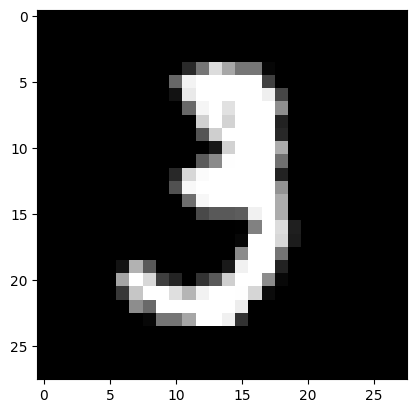

In [12]:
plt.imshow(image.reshape(28,28), cmap = "gray") 
plt.grid(False)
plt.show()

In [13]:
training_dataloader = DataLoader(dataset = training_data, batch_size = 64, shuffle = True)

test_dataloader = DataLoader(dataset = validation_data, batch_size = 64, shuffle = True) 

In [14]:
training_dataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [16]:
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet, self).__init__() 
    self.conv1 = nn.Conv2d(1,6,5) 
    self.pool1 = nn.MaxPool2d(2,2) 
    self.conv2 = nn.Conv2d(6,16,5) 
    self.pool2 = nn.MaxPool2d(2,2) 
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10) 


  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x))) 
    x = self.pool2(F.relu(self.conv2(x))) 
    x = torch.flatten(x,1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x)) 
    logits = self.fc3(x) 
    return logits

In [17]:
net = LeNet() 

print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
noise = torch.randn(size = (1,1,28,28))
predictions = net(noise) 
print(predictions)

tensor([[ 0.0645, -0.0362, -0.0662,  0.0591,  0.0394,  0.0579,  0.1180,  0.0286,
          0.0697,  0.0550]], grad_fn=<AddmmBackward0>)


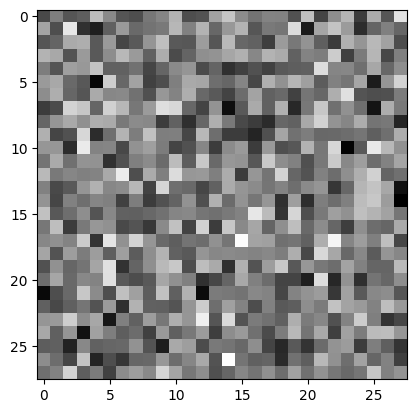

In [19]:
plt.imshow(noise.reshape(28,28), cmap = "gray") 
plt.grid(False)
plt.show()

In [20]:
loss_function = nn.CrossEntropyLoss() 

optimizer_function = torch.optim.Adam(net.parameters(), lr = 1e-3) 

In [30]:
x,y = next(iter(training_dataloader))
x.size(),y.size()

64

In [43]:
def train(dataloader, model, loss_fn, op_fn):
  size = len(training_dataloader.dataset)
  for batch, (x,y) in enumerate(dataloader): 
    #forward run
    y_pred = model(x) 
    loss = loss_fn(y_pred, y) 

    #backpropagation
    op_fn.zero_grad()
    loss.backward()
    op_fn.step()

    if batch % 100 ==0:

      loss, current = loss.item(), batch * len(x) 
      print(f"loss is {loss}  [{current} / {size}]")

In [41]:
def test(dataloader, model, loss_fn):

  size = len(dataloader.dataset)
  num_batches = len(dataloader) 
  correct, test_loss = 0,0 
  with torch.no_grad():
    for x,y in dataloader:
      y_pred = model(x) 
      test_loss += loss_fn(y_pred, y).item() 
      correct += (y_pred.argmax(1) == y).type(torch.float).sum().item() 
  test_loss /= num_batches 
  correct /= size 
  print(f"accuracy is {correct*100} test_loss is {test_loss}")


In [44]:
EPOCHS = 20 

for epochs in range(EPOCHS):
  print(f"epoch: {epochs+1} ---------------------------")
  train(training_dataloader, net, loss_function, optimizer_function)
  test(test_dataloader, net, loss_function) 

print('DONE') 

epoch: 1 ---------------------------
loss is 0.006118019577115774  [0 / 60000]
loss is 0.004824737552553415  [6400 / 60000]
loss is 0.09419170022010803  [12800 / 60000]
loss is 0.0012653374578803778  [19200 / 60000]
loss is 0.015593001618981361  [25600 / 60000]
loss is 0.10025688260793686  [32000 / 60000]
loss is 0.0028967740945518017  [38400 / 60000]
loss is 0.00011138830450363457  [44800 / 60000]
loss is 0.058395545929670334  [51200 / 60000]
loss is 0.019465766847133636  [57600 / 60000]
accuracy is 98.67 test_loss is 0.04310908425048032
epoch: 2 ---------------------------
loss is 0.02150736376643181  [0 / 60000]
loss is 0.004724208265542984  [6400 / 60000]
loss is 0.006683297920972109  [12800 / 60000]
loss is 0.058915529400110245  [19200 / 60000]
loss is 0.0003018583811353892  [25600 / 60000]
loss is 0.013195420615375042  [32000 / 60000]
loss is 0.037924107164144516  [38400 / 60000]
loss is 0.004244264680892229  [44800 / 60000]
loss is 0.0003448157222010195  [51200 / 60000]
loss is 